# Исследование надежности заемщиков.

# Описание проекта
Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.
Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

Необходимо ответить на вопросы:

* Есть ли зависимость между количеством детей и возвратом кредита в срок?
* Есть ли зависимость между семейным положением и возвратом кредита в срок?
* Как разные цели кредита влияют на его возврат в срок?

## Обзор данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    df = pd.read_csv('data.csv')
except:
    df = pd.read_csv('/datasets/data.csv')

display(df.head())
display(df.info())

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


None

## Заполнение пропусков

### Заполнение пропусков

In [3]:
display(pd.DataFrame(round((df.isna().mean()*100),2), columns=['NaNs, %']).style.format(
    '{:.2f}').background_gradient('coolwarm'))

,"NaNs, %"
children,0.00
days_employed,10.10
dob_years,0.00
education,0.00
education_id,0.00
family_status,0.00
family_status_id,0.00
gender,0.00
income_type,0.00
debt,0.00


Сколько значений пропущено в столбцах `days_employed` и `total_income`

In [4]:
print(f"Количество пропущенных значений в total_income: {df['total_income'].isna().sum()} \n\
Количество пропущенных значений в days_employed:{df['days_employed'].isna().sum()}")

Количество пропущенных значений в total_income: 2174 
Количество пропущенных значений в days_employed:2174


Проверим, что пропуски в столбцах совпадают по строкам

In [5]:
print(f"Пропуски совпадают: {(df['days_employed'].isna() == df['total_income'].isna()).sum() == df.shape[0]}")

Пропуски совпадают: True


В каких группах `income_type` пропущены значения

In [6]:
df[df['total_income'].isna()]['income_type'].value_counts()

income_type
сотрудник          1105
компаньон           508
пенсионер           413
госслужащий         147
предприниматель       1
Name: count, dtype: int64

#### Пропущенные значения
* Значения пропущены в столбцах days_employed и total_income
* Доля пропущенных значений составляет 10.1% для каждого столбца
* Пропущенные строки в total_income совпадают с пустыми строками в days_employed
* Данные могут быть пропущены из-за того, что их не предоставил заемщик, либо заемщик не работает официально. Также пропуски могли случиться из-за некорректной работы базы данных
* Заменить пропущенные значения на медианы лучше, чем на средние, так как на медиану не влияют сильные выбросы значений

Заполним пропущенные значения `total_income` медианными для каждой группы в `income_type`.

In [7]:
df['total_income'] = df['total_income'].fillna(df.groupby('income_type')['total_income'].transform('median'))
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,2.152500e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.652253e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,9.804367e+04
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.077982e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.425944e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,1.955499e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


### Проверка данных на аномалии и исправления.

Работа со столбцом days_employed

In [8]:
print(f"Количество отрицательных значений в days_employed: {len(df[df['days_employed'] < 0]['days_employed'])}")
print(f"Количество положительных значений в days_employed: {len(df[df['days_employed'] > 0]['days_employed'])}")

Количество отрицательных значений в days_employed: 15906
Количество положительных значений в days_employed: 3445


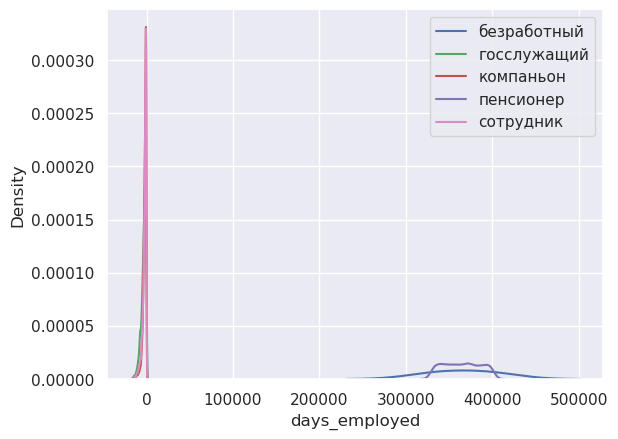

In [9]:
df.groupby('income_type')['days_employed'].apply(lambda x: sns.kdeplot(x, label = x.name))
plt.legend()
plt.xlabel('days_employed')
plt.show()

Большинство значений в столбце days_employed являются отрицательными. Исключениями являются группа пенсионеров и безработных. В данных группах значения можно поменять на 0, а в остальных заменить на значения по модулю.

In [10]:
df['days_employed'] = abs(df['days_employed'])

In [11]:
df['days_employed'].describe()

count     19351.000000
mean      66914.728907
std      139030.880527
min          24.141633
25%         927.009265
50%        2194.220567
75%        5537.882441
max      401755.400475
Name: days_employed, dtype: float64

Чтобы заполнить пропуски в столбце `days_employed`, сгруппируем людей по возрастам и заполним пропуки медиааными значениями стажа по возрасту.

Добавим группы по возрастам

In [12]:
df['dob_years'].min()

0

In [13]:
age_labels = ['yong', 'middle', 'old', 'retired']
age_bins = [df['dob_years'].min()-1, 30, 45, 63, df['dob_years'].max()]

df['age_groups'] = pd.cut(df['dob_years'],
                       bins=age_bins,
                       labels=age_labels)

Заполним пропущенные значения

In [14]:
df['days_employed'] = df['days_employed'].fillna(df.groupby('age_groups')['days_employed'].transform('median'))

Посмотрим на результат преобразований таблицы

In [15]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_groups
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,middle
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,middle
2,0,5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,middle
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,middle
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,old


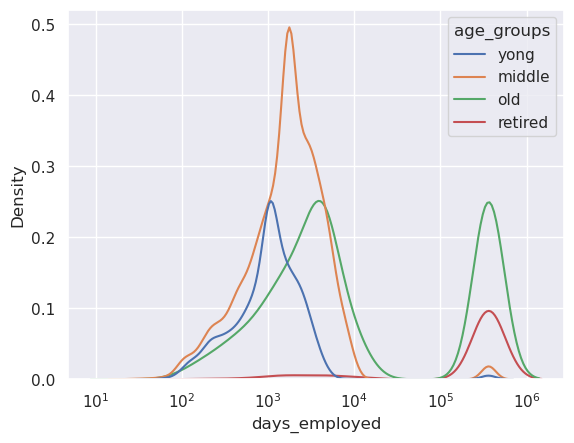

In [16]:
sns.kdeplot(x=df['days_employed'], hue=df['age_groups'], log_scale=True)
plt.xlabel('days_employed')
plt.show()

Стаж заполнен верно. Но существуют странные записи, которые говорят о том, что есть люди всех возрастов, которые работали больше 270 лет.

### Изменение типов данных.

In [17]:
# Замените вещественный тип данных в столбце total_income на целочисленный
df['total_income'] = df['total_income'].astype('int')
df['days_employed'] = df['days_employed'].astype('int')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   children          21525 non-null  int64   
 1   days_employed     21525 non-null  int64   
 2   dob_years         21525 non-null  int64   
 3   education         21525 non-null  object  
 4   education_id      21525 non-null  int64   
 5   family_status     21525 non-null  object  
 6   family_status_id  21525 non-null  int64   
 7   gender            21525 non-null  object  
 8   income_type       21525 non-null  object  
 9   debt              21525 non-null  int64   
 10  total_income      21525 non-null  int64   
 11  purpose           21525 non-null  object  
 12  age_groups        21525 non-null  category
dtypes: category(1), int64(7), object(5)
memory usage: 2.0+ MB


### Поиск аномалий в данных

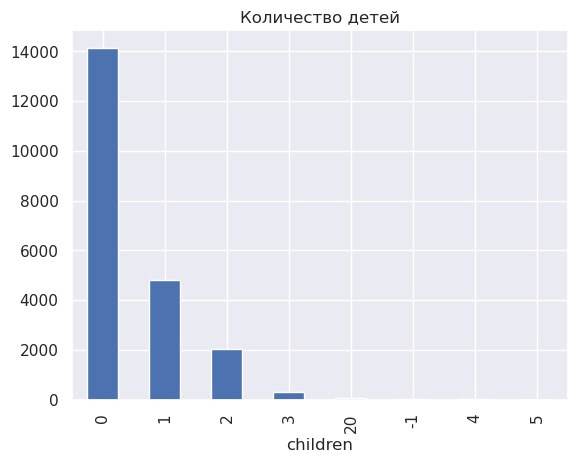

In [19]:
# посмотрим на данные во всех столбцах
df['children'].value_counts().plot(kind='bar')
plt.title('Количество детей')
plt.show()

Существуют анкеты с -1 ребенком, 20 детей тоже очень большая цифра

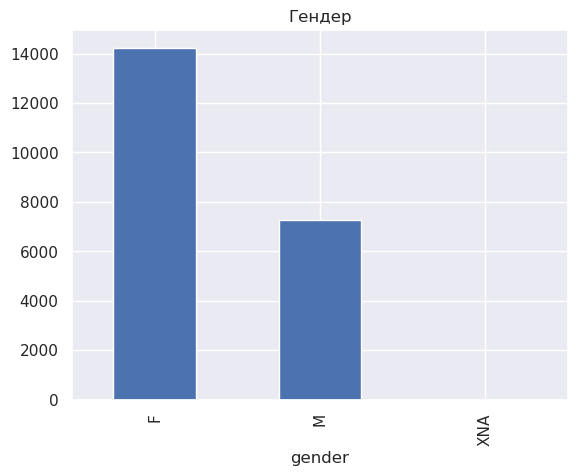

In [20]:
df['gender'].value_counts().plot(kind='bar')
plt.title('Гендер')
plt.show()

В данных есть анкеты с гендером XNA

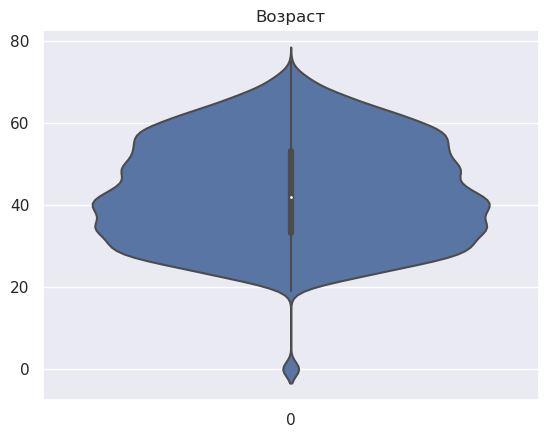

In [21]:
sns.violinplot(df['dob_years'])
plt.title('Возраст')
plt.show()

Существуют анкеты с возрастом 0 лет

In [22]:
# посчитаем уникальные значения в столбцах с аномалиями
print(f"Значения количества детей: {df['children'].value_counts().sort_values()}")
print()
print(f"Значения количества гендеров: {df['gender'].value_counts().sort_values()}")
print()
print(f"Кол-во анкет с возрастом 0: {df.query("dob_years < 1").shape[0]}")

Значения количества детей: children
 5         9
 4        41
-1        47
 20       76
 3       330
 2      2055
 1      4818
 0     14149
Name: count, dtype: int64

Значения количества гендеров: gender
XNA        1
M       7288
F      14236
Name: count, dtype: int64

Кол-во анкет с возрастом 0: 101


Уберем из анализа анкеты с аномальным количеством детей, непонятным гендером и возрастом равным 0.

In [23]:
df = df.query("(children>=0)&(children<6)&(gender != 'XNA')&(dob_years!=0)").reset_index(drop=True)

### Удаление дубликатов.

In [24]:
# дубликаты могут оказаться в столбцах education, family_status, income_type, purpose
def print_potential_duplicates():
    print('Значения в столбце education')
    display(df['education'].value_counts())
    print('Значения в столбце family_status')
    display(df['family_status'].value_counts())
    print('Значения в столбце income_type')
    display(df['income_type'].value_counts())
    print('Значения в столбце purpose')
    display(df['purpose'].value_counts())

print_potential_duplicates()   

Значения в столбце education


education
среднее                13609
высшее                  4666
СРЕДНЕЕ                  764
Среднее                  700
неоконченное высшее      662
ВЫСШЕЕ                   270
Высшее                   266
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: count, dtype: int64

Значения в столбце family_status


family_status
женат / замужем          12254
гражданский брак          4138
Не женат / не замужем     2783
в разводе                 1179
вдовец / вдова             947
Name: count, dtype: int64

Значения в столбце income_type


income_type
сотрудник          10996
компаньон           5033
пенсионер           3819
госслужащий         1447
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: count, dtype: int64

Значения в столбце purpose


purpose
свадьба                                   791
на проведение свадьбы                     768
сыграть свадьбу                           764
операции с недвижимостью                  670
покупка коммерческой недвижимости         658
покупка жилья для сдачи                   649
операции с коммерческой недвижимостью     644
операции с жильем                         642
покупка жилья для семьи                   639
жилье                                     636
покупка жилья                             635
недвижимость                              628
операции со своей недвижимостью           626
строительство собственной недвижимости    626
строительство недвижимости                620
строительство жилой недвижимости          619
покупка своего жилья                      618
покупка недвижимости                      615
ремонт жилью                              607
покупка жилой недвижимости                600
на покупку своего автомобиля              501
заняться высшим образовани

In [25]:
# Приведем все знаки в нижний регистр
col_names = ['education', 'family_status', 'income_type', 'purpose']
for name in col_names:
    df[name] = df[name].str.lower()

print_potential_duplicates()

Значения в столбце education


education
среднее                15073
высшее                  5202
неоконченное высшее      738
начальное                282
ученая степень             6
Name: count, dtype: int64

Значения в столбце family_status


family_status
женат / замужем          12254
гражданский брак          4138
не женат / не замужем     2783
в разводе                 1179
вдовец / вдова             947
Name: count, dtype: int64

Значения в столбце income_type


income_type
сотрудник          10996
компаньон           5033
пенсионер           3819
госслужащий         1447
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: count, dtype: int64

Значения в столбце purpose


purpose
свадьба                                   791
на проведение свадьбы                     768
сыграть свадьбу                           764
операции с недвижимостью                  670
покупка коммерческой недвижимости         658
покупка жилья для сдачи                   649
операции с коммерческой недвижимостью     644
операции с жильем                         642
покупка жилья для семьи                   639
жилье                                     636
покупка жилья                             635
недвижимость                              628
операции со своей недвижимостью           626
строительство собственной недвижимости    626
строительство недвижимости                620
строительство жилой недвижимости          619
покупка своего жилья                      618
покупка недвижимости                      615
ремонт жилью                              607
покупка жилой недвижимости                600
на покупку своего автомобиля              501
заняться высшим образовани

* Много неявных дубликатов в столбце purpose. 
* Значения можно объединить на группы: свадьба, покупка недвижимости, строительство или ремонт, покупка автомобиля, образование

### Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.

Для того, чтобы проще было обращаться с переменными, уберем из основной таблицы расшифровку значений `'education_id'` и `'family_status_id'` и создадим таблицы-словари с этими шифрами. 

In [26]:
# создаем таблицы-словари
education_decoder = df[['education', 'education_id']].drop_duplicates().reset_index(drop=True)
family_status_decoder = df[['family_status', 'family_status_id']].drop_duplicates().reset_index(drop=True)
display(education_decoder, family_status_decoder)

,education,education_id
0,высшее,0
1,среднее,1
2,неоконченное высшее,2
3,начальное,3
4,ученая степень,4


,family_status,family_status_id
0,женат / замужем,0
1,гражданский брак,1
2,вдовец / вдова,2
3,в разводе,3
4,не женат / не замужем,4


In [27]:
# убираем из таблицы education и family_status
df = df.drop(columns=['education', 'family_status'])
df.head()

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,age_groups
0,1,8437,42,0,0,F,сотрудник,0,253875,покупка жилья,middle
1,1,4024,36,1,0,F,сотрудник,0,112080,приобретение автомобиля,middle
2,0,5623,33,1,0,M,сотрудник,0,145885,покупка жилья,middle
3,3,4124,32,1,0,M,сотрудник,0,267628,дополнительное образование,middle
4,0,340266,53,1,1,F,пенсионер,0,158616,сыграть свадьбу,old


### Категоризация дохода.

In [28]:
def total_income_category(income):
    if income <= 30000:
        return 'E'
    if income <= 50000:
        return 'D'
    if income <= 200000:
        return 'C'
    if income <= 1000000:
        return 'B'
    if income > 1000000:
        return 'A'
    return 'неизвестная категория'

In [29]:
df['total_income_category'] = pd.cut(df['total_income'],
                                     labels=['A','B','C', 'D', 'E'],
                                     bins=[0, 30000, 50000, 200000, 1000000, df['total_income'].max()]
                                    )
df['total_income_category'].value_counts()

total_income_category
C    15920
D     4987
B      347
E       25
A       22
Name: count, dtype: int64

### Категоризация целей кредита.

In [30]:
def purpose_category(words):
    if 'свадьб' in words:
        return 'проведение свадьбы'
    if 'ремонт' in words or 'строит' in words:
        return 'ремонт и строительсвто'
    if 'авто' in words:
        return 'операции с автомобилем'
    if 'недвиж' in words or 'жил' in words:
        return 'операции с недвижимостью'
    if 'образован' in words or 'учеба' in words:
        return 'получение образования'
    return "неизвестная категория"

In [31]:
df['purpose_category'] = df['purpose'].apply(purpose_category)

In [32]:
df['purpose_category'].value_counts()

purpose_category
операции с недвижимостью    8260
операции с автомобилем      4267
получение образования       3979
ремонт и строительсвто      2472
проведение свадьбы          2323
Name: count, dtype: int64

### Ответы на вопросы.

In [33]:
print(f"Средняя доля должников в таблице: {df['debt'].mean() :.2%}")

Средняя доля должников в таблице: 8.09%


#### Есть ли зависимость между количеством детей и возвратом кредита в срок?

In [34]:
def answer_table(index, values='debt'):
    return_df = df.pivot_table(index=index, values=values,aggfunc={'count', 'sum', 'mean'})
    return_df = return_df.rename(columns={'mean':'debt ratio', 'sum':'n_debts', 'count':'n_observations'})
    return return_df

In [35]:
answer_table(index='children')

,n_observations,debt ratio,n_debts
children,,,
0,14079,0.075147,1058
1,4802,0.091837,441
2,2042,0.095005,194
3,328,0.082317,27
4,41,0.097561,4
5,9,0.000000,0


##### Вывод 1: 
* Заемщики без детей выплачивают кредиты вовремя чаще, чем заемщики с детьми. Доля должников по кредиту среди бездетных семей ниже, чем у семей с детьми и ниже среднего значения доли должников по всей таблице.
* В группах заемщиков с 1-4 детьми доля должников выше, чем доля должников во всей таблице.
* Заемщики с 5 детьми не имеют долгов по кредиту, однако для анализа таких семей мы имеем всего 9 наблюдений.

#### Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [36]:
family_df = answer_table('family_status_id')
family_df = family_df.merge(family_status_decoder, left_index=True, 
                            right_on='family_status_id')
family_df = family_df.drop(columns='family_status_id')
family_df.sort_values('debt ratio', ascending=False)

,n_observations,debt ratio,n_debts,family_status
4,2783,0.097736,272,не женат / не замужем
1,4138,0.092557,383,гражданский брак
0,12254,0.075322,923,женат / замужем
3,1179,0.071247,84,в разводе
2,947,0.065470,62,вдовец / вдова


##### Вывод 2: 
* Доля должников по кредиту выше всего у людей, никогда не состоявших в официальном браке и составляет более 9 %. Это выше доли должников во всей таблице.
* Доля должников среди состоящих в браке и разведенных людей составляет приблизительно 7 %. Меньше всего доля должников среди вдов и вдовцов — 6,6 %. Доля должников в этих группах меньше, чем доля должников во всей таблице.

##### Вопрос 3: 
Как разные цели кредита влияют на его возврат в срок?

In [37]:
answer_table('purpose_category').sort_values('debt ratio', ascending=False)

,n_observations,debt ratio,n_debts
purpose_category,,,
операции с автомобилем,4267,0.093040,397
получение образования,3979,0.092737,369
проведение свадьбы,2323,0.077916,181
операции с недвижимостью,8260,0.072518,599
ремонт и строительсвто,2472,0.072006,178


##### Вывод 3: 
* Доля невозвращенных кредитов больше всего среди операций, связанных с автомобилем и получением образования и выше доли должников по всей таблице. Доля задолженностей составляет примерно 9 %. 
* Заемы для проведения свадеб, операций с недвижимостью, а также ремонтом и строительсвтом являются более надежными. Доля задолженностей по кредиту среди этих категорий не превышает 7,8 % и ниже доли задолженностей по всей таблице.

## Общий вывод:

* Наличие детей и отсутствие официально оформленного брака повышает вероятность образования долга по кредиту.
* По кредитам для получения образования и операции с автомобилем более характерно образование задолженностей, чем по кредитам других групп.
* Результаты могут быть некорректными из-за большого количества пропущенных значений и аномалий в таблице